## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

# the usuals
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torchaudio.transforms as T
import tqdm
import scipy.signal as ss
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

# audio stuff
import librosa
from librosa import display
from scipy.io import wavfile
from pydub import AudioSegment
from IPython.display import Audio

# my own code
from inferencer import Inferencer
from energy import EnergyModel
from contrastive import ContrastiveModel
from datasets import VCTKDataset, VoxDataset

# ¡The Dataset(s)!

For this challenge, I used two datasets: the **VCTK** dataset (https://datashare.ed.ac.uk/handle/10283/3443) and the **VoxCeleb1** dataset (https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html). I do a little data exploration below.

## VCTK
The *CSTR VCTK Corpus: English Multi-speaker Corpus for CSTR Voice Cloning Toolkit* is a dataset from 2013 composed of English sentences spoken by 110 different speakers into the same microphone/room setup. Each speaker said about 400 sentences. 

I selected this dataset because it has sentences labeled by who said them (very useful for supervised speaker segmentation) and a nice, uniform recording setup that should make the data fairly clean. I consider this dataset to be the easy one, as the methods I applied always seemed to "solve" the dataset better than on **VoxCeleb1**. Also, the dataset sounds fairly uniform on an inter and intra-sentence level, although I'd like to think I normalize enough that that doesn't matter.

Here are some distributional statistics of the dataset. Figures taken from the paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6709856.

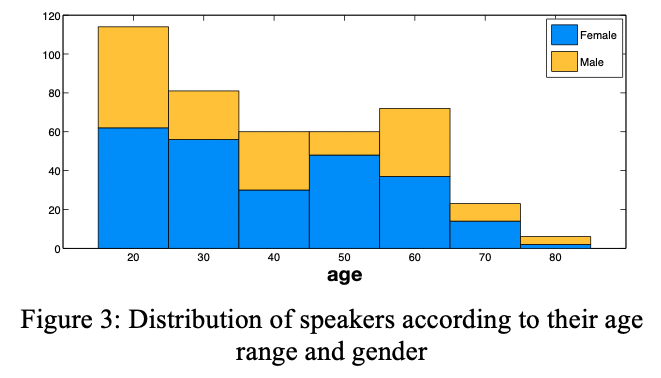
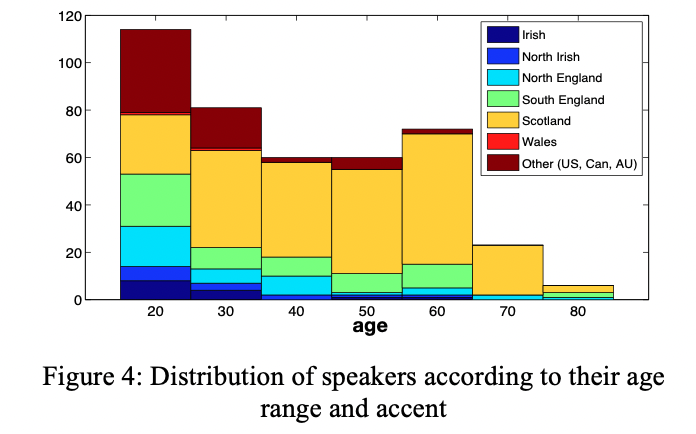

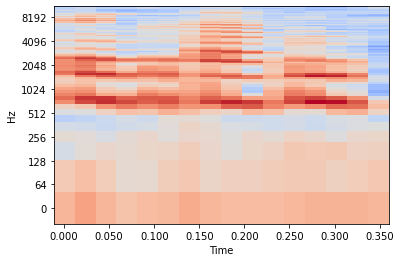

sample rate = 8000


In [2]:
# some example clips - let's listen to them and look at their spectrograms

# speaker p225
sr, p225_clip = wavfile.read('data/VCTK/p225_2.wav')
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=p225_clip, sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=p225_clip, rate=sr)

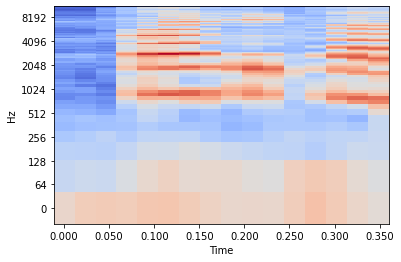

sample rate = 8000


In [3]:
# speaker p225 # 2
sr, p225_clip = wavfile.read('data/VCTK/p225_5.wav')
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=p225_clip, sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=p225_clip, rate=sr)

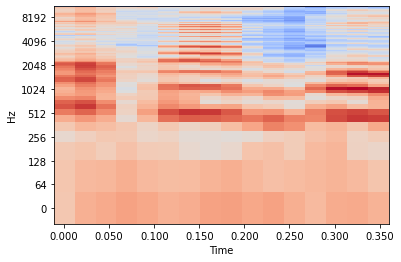

sample rate = 8000


In [4]:
# speaker p226
sr, p226_clip = wavfile.read('data/VCTK/p226_5.wav')
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=p226_clip, sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=p226_clip, rate=sr)

## VoxCeleb1
The *VoxCeleb1* is a 2017 audio-visual (although I only take the audio and labels) dataset of English sentences said by celebrities in youtube interviews. There are 1211 different speakers in this dataset (at least in the train split, which was all my computer could fit lol), totaling 148642 utterances, each of duration at least 3 seconds (see below). It was a total pain to get this dataset, since I had to contact the authors for permission to download the 39Gb dataset through a comically slow server they set up. 

I selected this dataset because it seemed to me to be more representative of the "wild", with different microphone setups, background noise, and conditions that are altogether less curated. Also, the larger number of speakers and datapoints gives models trained on this dataset a different flavor that I think is valuable to include. Everything sounds pretty good in this dataset, as far as microphone quality and audio balancing (as one would expect from an interview), and the dataset designers did a good job of stripping away silence and anomalous things, leaving a big and solid dataset.

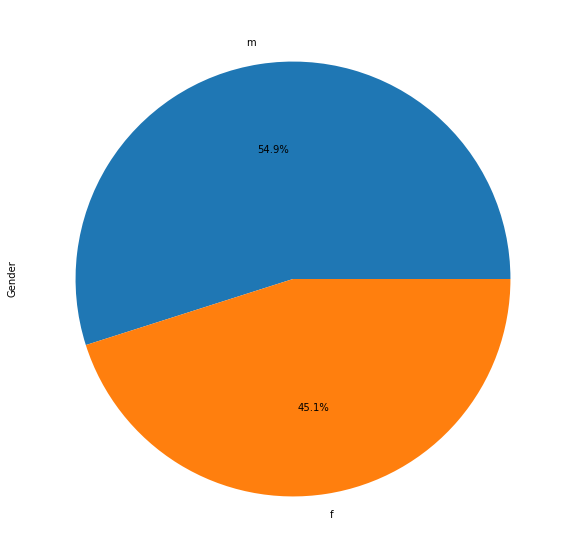

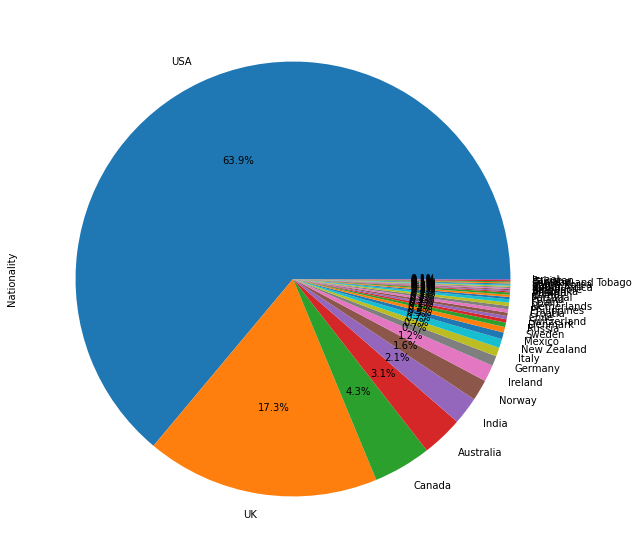

,VGGFace1 ID,Gender,Nationality,Set
VoxCeleb1 ID,,,,
id10001,A.J._Buckley,m,Ireland,dev
id10002,A.R._Rahman,m,India,dev
id10003,Aamir_Khan,m,India,dev
id10004,Aaron_Tveit,m,USA,dev
id10005,Aaron_Yoo,m,USA,dev


In [5]:
vox_metadata = pd.read_csv('data/vox1/vox1_meta.csv', delimiter='\t').set_index('VoxCeleb1 ID')
vox_metadata = vox_metadata[vox_metadata['Set'] == 'dev']

vox_metadata['Gender'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(16, 10))
plt.show()
vox_metadata['Nationality'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(16, 10))
plt.show()
vox_metadata.head()

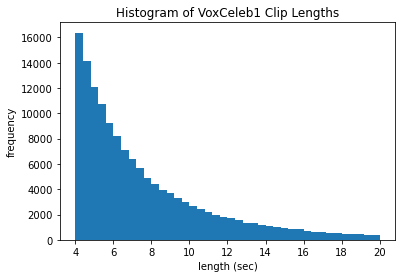

In [6]:
# look at clip lengths
vox_df = pd.read_csv('data/vox1/dataset.csv')
lengths = vox_df['len'].values
plt.hist(lengths, bins=40, range=(4, 20))
plt.title('Histogram of VoxCeleb1 Clip Lengths')
plt.xlabel('length (sec)')
plt.ylabel('frequency')
plt.show()

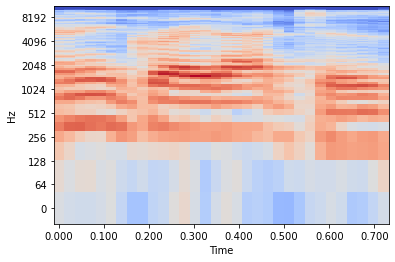

sample rate = 16000


In [7]:
# some example clips - let's listen to them and look at their spectrograms

# Alan_Rickman, id10022
sr, ar_clip = wavfile.read('data/vox1/id10022/mXLt0jhFiV4/00001.wav')
ar_clip = ar_clip / 2 ** 15
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=ar_clip[int(0.5 * sr): int(1.5 * sr)], sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=ar_clip, rate=sr)

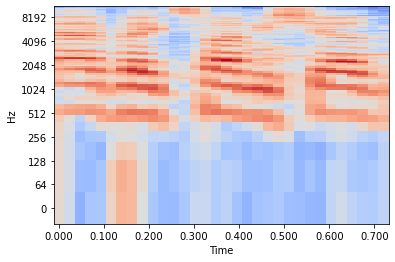

sample rate = 16000


In [8]:
# Cillian_Murphy, id10166
sr, cm_clip = wavfile.read('data/vox1/id10166/foLVL98ayhI/00001.wav')
cm_clip = cm_clip / 2 ** 15
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=cm_clip[int(0.5 * sr): int(1.5 * sr)], sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=cm_clip, rate=sr)

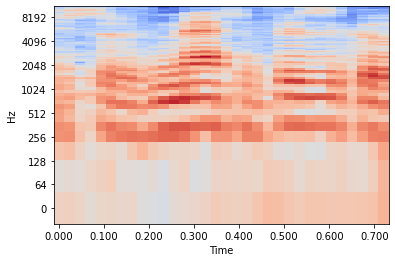

sample rate = 16000


In [9]:
# Cillian_Murphy # 2
sr, cm_clip = wavfile.read('data/vox1/id10166/PPZBsH24NyE/00002.wav')
cm_clip = cm_clip / 2 ** 15
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=cm_clip[int(0.5 * sr): int(1.5 * sr)], sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=cm_clip, rate=sr)

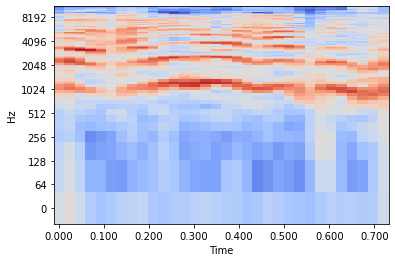

sample rate = 16000


In [10]:
# Miranda_Cosgrove, id10789
sr, mc_clip = wavfile.read('data/vox1/id10789/uH3cFAJv8xs/00001.wav')
mc_clip = mc_clip / 2 ** 15
spec = librosa.power_to_db(librosa.feature.melspectrogram(y=mc_clip[int(0.5 * sr): int(1.5 * sr)], sr=sr))
display.specshow(spec, x_axis='time', y_axis='log')
plt.show()
print(f'sample rate = {sr}')

Audio(data=mc_clip, rate=sr)

# ¡The Model(s)!
We decided above that we would featurize each clip using log-mel spectrograms in order to capture both frequency and time features (we expect frequency traits to be characteristic of certain speakers, but perhaps how quickly they modulate frequency and other time-dependent features are also useful). So, the model will take as input a 2D (normalized, log-mel) spectrogram over the *(time, frequency)* dimensions as input; clearly, it will be built with mainly Conv2D layers. (*I actually played around a bit with also having a head for 1D convolutions over the entire waveform that I would concatenate with the spectrogram head before passing to the body, but it was a waste of computation and parameters that only hurt*). I split my model engineering into two branches, which are related but different: 
- **(1)** contrastively learned speaker representations and
- **(2)** an energy-based speaker compatibility approach

I talk about these design decisions, the process, and the results below.

## Contrastive Model
As I was implementing early models for speaker classification or clip pair compatibility, I realized I was kind of dancing around explicitly learning speaker representations. The convolutional head in such models basically plays the role of an encoder, with the hope that the encoding relays speaker information and not much else. At that point, I might as well directly encode speakers, which is what I do here.

I frame the model in the traditional contrastive learning way: I wish to learn an embedding space that places clips from the same speaker together and clips from different speakers far away. One cool point in this setup is that I have the actual speaker labels and more than enough data, and so I don't really need augmentation for positive pair generation or anything. I don't do any hard negative mining because I didn't have the time or computational stuffs to get it done, but I imagine that would be a large area for improvement. So, everything that isn't a positive pair is equally negative. (*Cool side note: I actually pretrained these embedding models by attaching a linear classifier to the output and using cross-entropy loss over the task of speaker classification to get a rough first start - I then fine-tuned the embedding spaces with contrastive learning*). 

I experimented with a Triplet Loss for triplets of *(anchor, pos, neg)* and a supervised contrastive loss that uses the explicit labels to consider all possible pairs - as expected, the supervised contrastive loss does better, and so I stuck with that (*I also briefly tried InfoNCE, Soft Nearest Neighbors, and some of the other usual contrastive suspects, but I think the SupCon does better in the fully-supervised setting as the name suggests*). I trained one model for each dataset, since I think the different scales of speaker variation and dataset regularity would shake things up more in this setting than in the energy-based one. I didn't really put my all into a combined model, though, and if I had more time I would like to take a look at that too.

Below I visualize the generated embedding spaces and take a look at these models applied to a two speaker clip.

In [ ]:
# load dataframe linking .wav files to speakers
vctk_df = VCTKDataset('all').df.iloc[:10000]  # only first 10k points

# load models
vctk = ContrastiveModel.load('checkpoints/models/vctk_emb.pth').toggle_emb_mode().eval()

# embed the VCTK dataset!
print('TSNE\'ing VCTK')
with torch.no_grad():
    embs = []
    labels = []
    for path, label in tqdm.tqdm(zip(vctk_df['path'], vctk_df['id_str']), total=len(vctk_df)):
        sr, data = wavfile.read(f'data/VCTK/{path}')  # read in wavfile
        embs.append(vctk.emb(torch.tensor(data).reshape(1, -1)).numpy())  # embed
        labels.append(label)
X = np.concatenate(embs, axis=0)

# compute TSNE using cosine distance in the embedding space
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
X_t = TSNE(metric="precomputed", square_distances=True).fit_transform(distance_matrix)

vctk_tsne_df = pd.DataFrame()
vctk_tsne_df['tsne-one'] = X_t[:,0]
vctk_tsne_df['tsne-two'] = X_t[:,1]
vctk_tsne_df['speaker label'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="speaker label",
    palette=sns.color_palette("hls", 21),  # 21 different speakers in the first 10k data points
    data=vctk_tsne_df,
    legend="full",
    alpha=0.3
)
plt.title('Embedding Space Visualized for first 10k Points of VCTK Dataset')
plt.show()

preparing VCTK:all dataset
Turned embedding mode on!
TSNE'ing VCTK


  8%|█████████████▉                                                                                                                                                            | 817/10000 [00:04<00:48, 190.86it/s]

In [ ]:
# do the same thing with VoxCeleb1!
vox_df = VoxDataset('all', 111).df
vox_metadata = pd.read_csv('data/vox1/vox1_meta.csv', delimiter='\t').set_index('VoxCeleb1 ID')

vox = ContrastiveModel.load('checkpoints/models/vox_emb.pth').toggle_emb_mode().eval()

print('TSNE\'ing VoxCeleb1')
with torch.no_grad():
    embs = []
    labels = []
    for path, label in tqdm.tqdm(zip(vox_df['path'], vox_df['speaker']), total=647):
        sr, data = wavfile.read(f'data/vox1/{path}')
        for d in np.split(data, np.arange(0, len(data), int(0.5 * sr)))[1:-1]:  # split into 0.5s sections
            embs.append(vox.emb(torch.tensor(d / 2 ** 15).reshape(1, -1)).numpy())
            labels.append(vox_metadata.loc[f'id{label}']['VGGFace1 ID'])
        if len(embs) > 10000: break  # first 10k points
X = np.concatenate(embs, axis=0)

distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
X_t = TSNE(metric="precomputed", square_distances=True).fit_transform(distance_matrix)

vox_tsne_df = pd.DataFrame()
vox_tsne_df['tsne-one'] = X_t[:,0]
vox_tsne_df['tsne-two'] = X_t[:,1]
vox_tsne_df['speaker label'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="speaker label",
    palette=sns.color_palette("hls", 3),  # 3 speakers in the first 10k points
    data=vox_tsne_df,
    legend="full",
    alpha=0.3
)
plt.title('Embedding Space Visualized for first 10k Points of Vox Dataset')
plt.show()

In [ ]:
# Take a look at how these models do on some podcast data
sample_audio = AudioSegment.from_file('/Users/evandigiorno/Downloads/podcast.mp3')  # this has 2 channels, lets pick one
start = 0  # how many in seconds to start 
duration = 3000  # how many seconds to look at
num_points = 3000  # how many points to try
query_length = 0.5  # length of each clip to embed

sr = sample_audio.frame_rate
audio_data = np.array(sample_audio.get_array_of_samples()).reshape(-1, 2)[start * sr: (start + duration) * sr, 0] / 2 ** 15

# embed with both models
vctk = ContrastiveModel.load('checkpoints/models/vctk_emb.pth').toggle_emb_mode().eval()
vox = ContrastiveModel.load('checkpoints/models/vox_emb.pth').toggle_emb_mode().eval()
vctk_embs = []
vox_embs = []
labels = []
vctk_resampler = T.Resample(sr, 8000) # vctk is trained on 8k audio
vox_resampler = T.Resample(sr, 16000) # vox is trained on 16k audio
with torch.no_grad():
    data = torch.tensor(audio_data).float()
    for p in tqdm.tqdm(np.linspace(int(query_length * sr), len(audio_data), num_points)):
        p = int(p)
        clip = data[p - int(query_length * sr): p].reshape(1, -1)
        
        s = librosa.feature.melspectrogram(y=clip.squeeze().numpy())
        labels.append('Payton' if np.argmax(np.mean(s, axis=1)) > 2 else 'Garrett')  # heuristic "labeller"
        
        vctk_embs.append(vctk.emb(vctk_resampler(clip)).numpy())
        vox_embs.append(vox.emb(vox_resampler(clip)).numpy())

# TSNE embedding space for VCTK
X_vctk = np.concatenate(vctk_embs, axis=0)
distance_matrix_vctk = pairwise_distances(X_vctk, X_vctk, metric='cosine', n_jobs=-1)
X_t_vctk = TSNE(metric="precomputed", square_distances=True).fit_transform(distance_matrix_vctk)

vctk_tsne_df = pd.DataFrame()
vctk_tsne_df['tsne-one'] = X_t_vctk[:,0]
vctk_tsne_df['tsne-two'] = X_t_vctk[:,1]
vctk_tsne_df['speaker label'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="speaker label",
    palette=sns.color_palette("hls", 2),  # 2 speakers in the clip
    data=vctk_tsne_df,
    legend="full",
    alpha=0.3
)
plt.title('Embedding Space Visualized for Sample Podcast Using VCTK Model')
plt.show()

# TSNE embeddings space for Vox
X_vox = np.concatenate(vox_embs, axis=0)
distance_matrix_vox = pairwise_distances(X_vox, X_vox, metric='cosine', n_jobs=-1)
X_t_vox = TSNE(metric="precomputed", square_distances=True).fit_transform(distance_matrix_vox)

vox_tsne_df = pd.DataFrame()
vox_tsne_df['tsne-one'] = X_t_vox[:,0]
vox_tsne_df['tsne-two'] = X_t_vox[:,1]
vox_tsne_df['speaker label'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="speaker label",
    palette=sns.color_palette("hls", 2),  # 2 speakers in the clip
    data=vox_tsne_df,
    legend="full",
    alpha=0.3
)
plt.title('Embedding Space Visualized for Sample Podcast Using Vox Model')
plt.show()

## Energy-Based Model
With the contrastive framework we made above, we now want to be able to differentiate between two different speakers. While this could be done simply with the cosine similarity between the embeddings of two clips, I decided to train a downstream model that takes the embeddings as input and outputs a compatibility score. My mind immediately turned to this perspective, most likely because while I was thinking about this I was also putting together a presentation on physics-inspired deep learning and energy models for the AI club I run here at Princeton. The actual stuff I was presenting was kinda different, but the perspective of learning an energy landscape for pairwise compatibility was certainly on my mind. 

I actually frame this approach as follows: since the problem centers around detecting when the active speaker changes, a useful subproblem is to be able to distinguish if speakers in two clips are the same speaker or not. The energy model then takes two inputs - the two (not necessarily adjacent) clips - and outputs a prediction for whether the two clips come from the same speaker or not, without the need to explicitly identify any speakers. This is basically a binary classification problem (in fact I use binary cross entropy loss over the output logits to train this) but I began thinking about it with more involved energy-based machinery and loss function wizardry like hinge and triplet and LVQ2 losses - this is why I call it the "energy-based model" everywhere in the code (plus it sounds cooler). I sample positive pairs with 0.3 probability in the dataloader and go at it! 

Below I take some examples from both datasets and look at how the combined contrastive + energy models do. I also build a confusion matrix in order to see the distribution of error.

### VCTK Confusion Matrix

In [ ]:
# VCTK
num_points = 4000  # how many inferences through model to test
num_speakers = 12  # how many speakers to look at

# dataset and model
vctk_dataloader = VCTKDataset('test', num_speakers).get_dataloader(1)
vctk_energy = EnergyModel.load('checkpoints/models/vctk_energy.pth').eval()

# construct confusion matrix
n = int(np.sqrt(num_points))
ret = defaultdict(list)
seen = {}
for i, ((clip1,), label1) in enumerate(tqdm.tqdm(vctk_dataloader, total=n)):
    for j, ((clip2,), label2) in enumerate(vctk_dataloader):
        l1 = min(label1, label2).item()
        l2 = max(label1, label2).item()
        ret[(l1, l2)].append(torch.sigmoid(vctk_energy(clip1, clip2)).item())
        if l1 not in seen: seen[l1] = len(seen)
        if l2 not in seen: seen[l2] = len(seen)
        if j >= n: break
    if i >= n: break

confusion_matrix = np.full((num_speakers, num_speakers), fill_value=0, dtype=float)
for k in ret.keys():
    l1, l2 = k
    v = np.mean(ret[k])
    confusion_matrix[seen[l1], seen[l2]] = v
    confusion_matrix[seen[l2], seen[l1]] = v
    
confusion_df = pd.DataFrame(confusion_matrix, range(num_speakers), range(num_speakers))
plt.figure(figsize=(16,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_df, annot=True, annot_kws={"size": 14}) # font size
plt.title('Confusion Matrix for Speaker Energy on VCTK Dataset')
plt.show()

### Vox Confusion Matrix

In [ ]:
# VOX
num_points = 10000  # how many inferences through model to test
num_speakers = 12  # how many speakers to look at

# dataset and model
vox_dataloader = VoxDataset('all', num_speakers).get_dataloader(1)
vox_energy = EnergyModel.load('checkpoints/models/vox_energy.pth').eval()

# construct confusion matrix
n = int(np.sqrt(num_points))
ret = defaultdict(list)
seen = {}
for i, ((clip1,), label1) in enumerate(tqdm.tqdm(vox_dataloader, total=n)):
    for j, ((clip2,), label2) in enumerate(vox_dataloader):
        l1 = min(label1, label2).item()
        l2 = max(label1, label2).item()
        ret[(l1, l2)].append(torch.sigmoid(vox_energy(clip1, clip2)).item())
        if l1 not in seen: seen[l1] = len(seen)
        if l2 not in seen: seen[l2] = len(seen)
        if j >= n: break
    if i >= n: break

confusion_matrix = np.full((num_speakers, num_speakers), fill_value=0, dtype=float)
for k in ret.keys():
    l1, l2 = k
    v = np.mean(ret[k])
    confusion_matrix[seen[l1], seen[l2]] = v
    confusion_matrix[seen[l2], seen[l1]] = v
    
confusion_df = pd.DataFrame(confusion_matrix, range(num_speakers), range(num_speakers))
plt.figure(figsize=(16,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_df, annot=True, annot_kws={"size": 14}) # font size
plt.title('Confusion Matrix for Speaker Energy on Vox Dataset')
plt.show()

# Trying it Out
With these components (two contrastive models with energy heads), I can try and tackle the general problem outside the domain of my datasets! Clearly, the idea is to compare the current window of speech to whatever came before it (the context) with these speaker comparison tools, and whenever the difference is staggering I declare that the speaker has changed. Because there are 4 models, each with their own qualities that make it useful, I can't definitively say which model is "right" and should be followed. So, I tried to implement as robust of a decoding process as possible by combining the outputs of the energy models finding peaks. If I had more time, I would have improved one of the models to the point where it was all that was needed and I could discard the rest, but I actually enjoyed balancing everything together to get an end result I could live with. 

I downloaded mp3's of a **2-person murder mystery podcast**, a **post-fight interview**, and a **segment of a movie** so that my framework has some "wild" data to play with. I visualize results from clips from each of these 3 below.

In [ ]:
def inference_on_audio(audio, start, duration, channels):
    # all of the below hyperparameters are in seconds
    CONTEXT_WINDOW_SIZE = 2.  # how far in the past to compare. lower value for more responsive, but less precise model
    QUERY_DURATION = 0.5  # how long each query clip is. lower value for more responsive, but less precise model
    res = 0.2  # step size between each query. lower value for more precise, but slower model
    
    sr = audio.frame_rate
    data = np.array(audio.get_array_of_samples()).reshape(-1, channels)[start * sr: (start + duration) * sr]
    data = data[:, 0] / 2 ** 15

    inf = Inferencer(sr)

    rets = []
    vals = []
    ts = []

    i = CONTEXT_WINDOW_SIZE
    
    while i <= len(data) // sr - 2 * QUERY_DURATION:
        before = data[round(sr * (i - CONTEXT_WINDOW_SIZE)):round(sr * i)]
        curr = data[round(sr * i): round(sr * (QUERY_DURATION + i))]

        if np.var(before) < 1e-4 or np.var(curr) < 1e-4:
            i += res
            continue

        ret, a = inf.infer(before, curr)
        rets.append(ret)
        vals.append(a)
        ts.append(i + QUERY_DURATION - duration)

        i += res

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(np.arange(len(data)) / sr - duration, data)
    ax[0].set_title('Predicted Speaker Changes (red)')

    peaks, _ = ss.find_peaks(np.array(rets), threshold=0.0025, distance=4)
    peak_values = [rets[i] for i in peaks]
    peak_times = [ts[i] for i in peaks]
    max_peak = np.max(peak_values)
    for val, t in zip(peak_values, peak_times):
        if val > max_peak / 3:
            ax[0].axvline(t, color='r', linewidth=4)
            
    vals = np.array(vals)
    ts = np.array(ts)
    ax[1].set_title('Model Outputs')
    ax[1].plot(ts, vals[:, 0], color='red', label='vctk energy')
    ax[1].plot(ts, vals[:, 1], color='orange', label='vctk sim')
    ax[1].plot(ts, vals[:, 2], color='blue', label='vox energy')
    ax[1].plot(ts, vals[:, 3], color='green', label='vox sim')
    ax[1].plot(ts, vals[:, 0] * vals[:, 2], color='purple', linewidth=5, label='decider')
    ax[1].legend()
    fig.show()
    return data, sr

In [ ]:
# two-person murder mystery podcast - Murder with my Husband
audio = AudioSegment.from_file('/Users/evandigiorno/Downloads/podcast.mp3')
data, sr = inference_on_audio(audio, start=710, duration=20, channels=2)
Audio(data=data, rate=sr)

In [ ]:
# post-fight press conference with Israel Adesanya
audio = AudioSegment.from_file('/Users/evandigiorno/Downloads/fight.mp3')
data, sr = inference_on_audio(audio, start=55, duration=15, channels=2)
Audio(data=data, rate=sr)

In [ ]:
# coin flip scene from the movie No Country for Old Men
audio = AudioSegment.from_file('/Users/evandigiorno/Downloads/movie.mp3')
data, sr = inference_on_audio(audio, start=55, duration=15, channels=2)
Audio(data=data, rate=sr)